In [ ]:
from IPython.display import clear_output
!pip install --upgrade pip
!pip install --upgrade pip
!pip install tensorflow==2.4.1
!pip install -U tensorflow-quantum
!pip install cirq
clear_output()

In [ ]:
import os
import random
import PIL
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import tensorflow_quantum as tfq
import cirq
import sympy

from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.datasets import fashion_mnist as dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = dataset.load_data()

In [ ]:
def filter_data(x, y):
  keep = (y == 5) | (y == 9)
  x, y = x[keep], y[keep]
  y = y == 5
  return x,y

In [ ]:
#Filter the train set
X_train, y_train = filter_data(X_train, y_train)

#Filter the test_set
X_test, y_test = filter_data(X_test, y_test)

In [ ]:
print("The shape of the X_train is {}".format( X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_test is {}".format(X_test.shape))
print("The shape of the y_test is {}".format(y_test.shape))

The shape of the X_train is (12000, 28, 28)
The shape of the y_train is (12000,)
The shape of the X_test is (2000, 28, 28)
The shape of the y_test is (2000,)


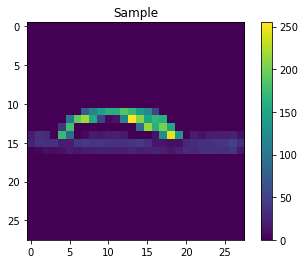

In [ ]:
plt.imshow(X_train[14])
plt.colorbar()
plt.title('Sample')
plt.show()

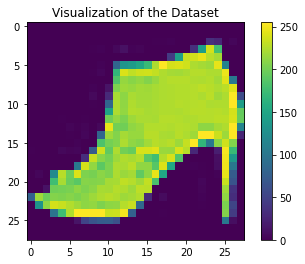

In [ ]:
plt.imshow(X_train[15])
plt.colorbar()
plt.title('Visualization of the Dataset')
plt.show()

## Preprocessing Steps

In [ ]:
X_train = X_train / 255.0
X_test = X_test/ 255.0

In [ ]:
X_train = X_train.reshape(X_train.shape[0], *(28,28,1))
X_test = X_test.reshape(X_test.shape[0], *(28,28,1))

In [ ]:
X_train = tf.image.resize(X_train, (2,2)).numpy()
X_test = tf.image.resize(X_test, (2,2)).numpy()

In [ ]:
#Splitting the training fdataset into train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.15, random_state=0)

In [ ]:
print("The shape of the X_train is {}".format(X_train.shape))
print("The shape of the y_train is {}".format(y_train.shape))
print("The shape of the X_valid is {}".format(X_valid.shape))
print("The shape of the y_valid is {}".format(y_valid.shape))

The shape of the X_train is (10200, 2, 2, 1)
The shape of the y_train is (10200,)
The shape of the X_valid is (1800, 2, 2, 1)
The shape of the y_valid is (1800,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], *(1,4,1))
X_valid = X_valid.reshape(X_valid.shape[0], *(1,4,1))
X_test = X_test.reshape(X_test.shape[0], *(1,4,1))

In [ ]:
print(X_train[0])

[[[0.        ]
  [0.41568628]
  [0.7137255 ]
  [0.73921573]]]


In [ ]:
def binary_encode(X,threshold=0.5):
  encoded_images = list()
  for image in X:
    encoded_image = [1 if j>threshold else 0 for j in image[0]]
    encoded_images.append(encoded_image)
  return np.array(encoded_images)

In [ ]:
X_train = binary_encode(X_train)

In [ ]:
print(X_train[0])

[0 0 1 1]


In [ ]:
def create_circuit_from_image(encoded_image):
  qubits = cirq.GridQubit.rect(2,2)
  circuit = cirq.Circuit()
  for i, pixel in enumerate(encoded_image):
    if pixel:
      circuit.append(cirq.X(qubits[i]))
  return circuit

In [ ]:
X_train_q = [create_circuit_from_image(encoded_image) for encoded_image in X_train]

In [ ]:
print(X_train[15])

[0 1 1 0]


In [ ]:
print(X_train_q[15])

(0, 1): ───X───

(1, 0): ───X───


# Step 2: Converting Cirq Circuits to tfq Tensors

In [ ]:
X_train_tfq = tfq.convert_to_tensor(X_train_q)

In [ ]:
X_valid = binary_encode(X_valid)
X_test = binary_encode(X_test)

In [ ]:
X_valid_q = [create_circuit_from_image(encoded_image) for encoded_image in X_valid]
X_test_q = [create_circuit_from_image(encoded_image) for encoded_image in X_test]

In [ ]:
X_valid_tfq = tfq.convert_to_tensor(X_valid_q)
X_test_tfq = tfq.convert_to_tensor(X_test_q)

# Quantum Neural Network

## Build the QNN

In [ ]:
class QNN():
    def __init__(self, data_qubits, readout):
      self.data_qubits = data_qubits
      self.readout = readout

    def add_layer(self, circuit, gate, symbol_gate):
      for i, qubit in enumerate(self.data_qubits):
        symbol = sympy.Symbol(symbol_gate+ '-' + str(i))
        circuit.append(gate(qubit, self.readout)**symbol)

In [ ]:
def create_qnn():
    data_qubits = cirq.GridQubit.rect(2,2)
    readout = cirq.GridQubit(-1, -1)
    circuit = cirq.Circuit()

    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    qnn = QNN(
        data_qubits = data_qubits,
        readout=readout)
    
    qnn.add_layer(circuit, cirq.XX, "xx")
    qnn.add_layer(circuit, cirq.ZZ, "zz")

    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
qmodel, model_readout = create_qnn()

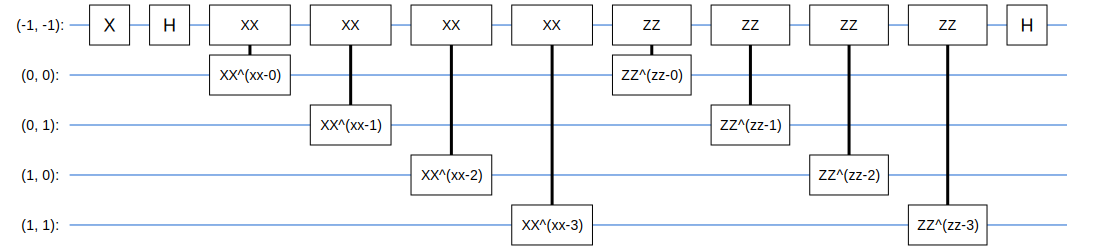

In [ ]:
SVGCircuit(qmodel)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(qmodel, model_readout),
])

In [ ]:
y_train_h = np.array([1 if i==1 else -1 for i in y_train ])
y_valid_h = np.array([1 if i==1 else -1 for i in y_valid ])
y_test_h = np.array([1 if i==1 else -1 for i in y_test ])

In [ ]:
print(y_train_h[0])

1


In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[hinge_accuracy])

In [ ]:
qnn_history = model.fit(
      X_train_tfq, y_train_h,
      batch_size=64,
      epochs=10,
      verbose=1,
      validation_data=(X_valid_tfq, y_valid_h))

Epoch 1/10
160/160 [==============================] - 9s 48ms/step - loss: 1.0470 - hinge_accuracy: 0.3970 - val_loss: 0.9356 - val_hinge_accuracy: 0.5528
Epoch 2/10
160/160 [==============================] - 7s 47ms/step - loss: 0.8845 - hinge_accuracy: 0.5799 - val_loss: 0.7840 - val_hinge_accuracy: 0.6573
Epoch 3/10
160/160 [==============================] - 7s 46ms/step - loss: 0.7384 - hinge_accuracy: 0.6621 - val_loss: 0.6028 - val_hinge_accuracy: 0.6514
Epoch 4/10
160/160 [==============================] - 7s 47ms/step - loss: 0.5405 - hinge_accuracy: 0.7779 - val_loss: 0.4011 - val_hinge_accuracy: 0.8351
Epoch 5/10
160/160 [==============================] - 7s 45ms/step - loss: 0.4103 - hinge_accuracy: 0.8302 - val_loss: 0.3908 - val_hinge_accuracy: 0.8351
Epoch 6/10
160/160 [==============================] - 7s 45ms/step - loss: 0.3901 - hinge_accuracy: 0.8367 - val_loss: 0.3924 - val_hinge_accuracy: 0.8351
Epoch 7/10
160/160 [==============================] - 7s 44ms/step - l

In [ ]:
model.evaluate(X_test_tfq, y_test_h)

63/63 [==============================] - 1s 13ms/step - loss: 0.3708 - hinge_accuracy: 0.8229


[0.3708268404006958, 0.8229166865348816]

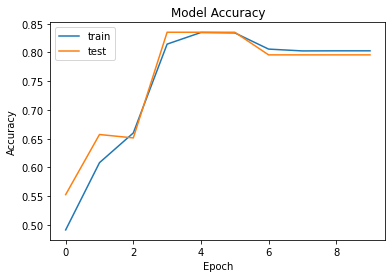

In [ ]:
# Visualize Accuracy
plt.plot(qnn_history.history['hinge_accuracy'])
plt.plot(qnn_history.history['val_hinge_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc="best")
plt.show()

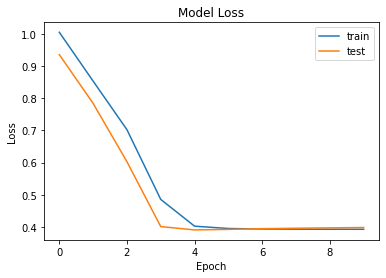

In [ ]:
# Visualize Loss
plt.plot(qnn_history.history['loss'])
plt.plot(qnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'],loc="best")
plt.show()

In [ ]:
# Save The Model Weights
model.save_weights('/content/sample_data/QModelWeights')

# ANN

## Build ANN

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model2.fit(
      X_train, y_train,
      batch_size=64,
      epochs=10,
      verbose=1,
      validation_data=(X_valid, y_valid))

Epoch 1/10
160/160 [==============================] - 1s 6ms/step - loss: 10.9358 - accuracy: 0.8793 - val_loss: 1.9444 - val_accuracy: 0.9528
Epoch 2/10
160/160 [==============================] - 1s 4ms/step - loss: 1.2477 - accuracy: 0.9706 - val_loss: 4.3674 - val_accuracy: 0.9206
Epoch 3/10
160/160 [==============================] - 1s 4ms/step - loss: 1.6407 - accuracy: 0.9643 - val_loss: 0.6142 - val_accuracy: 0.9822
Epoch 4/10
160/160 [==============================] - 1s 4ms/step - loss: 0.4610 - accuracy: 0.9836 - val_loss: 1.2221 - val_accuracy: 0.9639
Epoch 5/10
160/160 [==============================] - 1s 4ms/step - loss: 0.4561 - accuracy: 0.9868 - val_loss: 0.5403 - val_accuracy: 0.9828
Epoch 6/10
160/160 [==============================] - 1s 4ms/step - loss: 0.3240 - accuracy: 0.9872 - val_loss: 0.8585 - val_accuracy: 0.9783
Epoch 7/10
160/160 [==============================] - 1s 4ms/step - loss: 0.2107 - accuracy: 0.9900 - val_loss: 0.4517 - val_accuracy: 0.9844
Epoch

## ANN Metrics

In [ ]:
model2.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.7578 - accuracy: 0.9820


[0.7578238844871521, 0.9819999933242798]

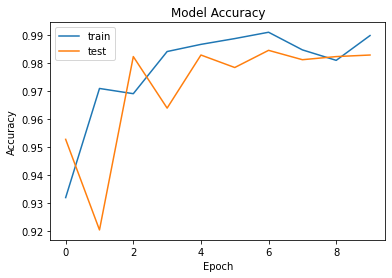

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc="best")
plt.show()

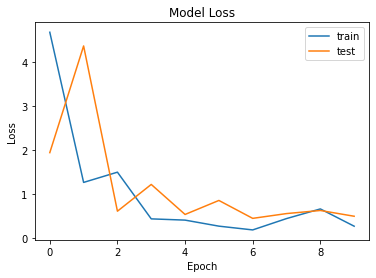

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'],loc="best")
plt.show()